# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, re, math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, CuDNNLSTM, Bidirectional, Reshape, Flatten
from keras.preprocessing import text
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import utils
from gensim.models import Word2Vec
%matplotlib inline

/opt/anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data

In [2]:
train = pd.read_csv('train.csv').iloc[:, :-1]
test = pd.read_csv('test.csv').iloc[:, :-1]
submission = pd.read_csv('data_info_val_sample_submission.csv')
with open('categories.json') as f:
    categories = json.load(f)

# Preprocess

In [3]:
def preprocessing(titles_array):
    processed_array = []
    for title in titles_array:
        processed = re.sub('[^a-zA-Z ]', '', title)
        words = processed.split()
        processed_array.append(' '.join([word for word in words if len(word) > 1]))
    return processed_array

In [4]:
train['processed'] = preprocessing(train['title'])
test['processed'] = preprocessing(test['title'])

In [5]:
x, y = train['processed'].values, train['Category'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2019, shuffle=True, stratify=y)

In [ ]:
sentences = pd.concat([train['processed'], test['processed']],axis=0)
train_sentences = list(sentences.apply(str.split).values)

w2v = Word2Vec(sentences=train_sentences, 
                 sg=1, 
                 size=100,  
                 workers=4)

w2v.wv.save_word2vec_format('custom_glove_100d.txt')

In [6]:
embeddings_index = {}
f = open('custom_glove_100d.txt')
for line in f:
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 16690 word vectors.


In [9]:
def text_to_array(text):
    empyt_emb = np.zeros(100)
    text = str(text)
    text = text.split()[:100]
    embeds = [embeddings_index.get(x, empyt_emb) for x in text]
    embeds += [empyt_emb] * (100 - len(embeds))
    return np.array(embeds)

In [10]:
x_train_vec = np.array([text_to_array(_) for _ in x_train])
x_test_vec = np.array([text_to_array(_) for _ in x_test])

# Model

In [11]:
y_train = utils.to_categorical(y_train, 58)
y_test = utils.to_categorical(y_test, 58)

In [22]:
batch_size = 32
epochs = 20

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True), input_shape=(100, 100)))
model.add(Dropout(0.05))
model.add(Bidirectional(CuDNNLSTM(128)))
model.add(Dense(58, activation=tf.nn.softmax))

callbacks = [
    ModelCheckpoint('rnn.h5', monitor='test_acc', verbose=1), 
    CSVLogger('nn1.csv', separator=',', append=False)
]

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 100, 256)          235520    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               395264    
_________________________________________________________________
dense_12 (Dense)             (None, 58)                14906     
Total params: 645,690
Trainable params: 645,690
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(x_train_vec, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/20
599953/599953 [==============================] - 697s 1ms/step - loss: 1.0180 - acc: 0.6837

Epoch 00001: saving model to rnn.hdf5
Epoch 2/20
599953/599953 [==============================] - 696s 1ms/step - loss: 0.8954 - acc: 0.7147

Epoch 00002: saving model to rnn.hdf5
Epoch 3/20
599953/599953 [==============================] - 696s 1ms/step - loss: 0.8430 - acc: 0.7288

Epoch 00003: saving model to rnn.hdf5
Epoch 4/20
599953/599953 [==============================] - 694s 1ms/step - loss: 0.8050 - acc: 0.7394

Epoch 00004: saving model to rnn.hdf5
Epoch 5/20
599953/599953 [==============================] - 694s 1ms/step - loss: 0.7727 - acc: 0.7485

Epoch 00005: saving model to rnn.hdf5
Epoch 6/20
599953/599953 [==============================] - 693s 1ms/step - loss: 0.7463 - acc: 0.7561

Epoch 00006: saving model to rnn.hdf5
Epoch 7/20
599953/599953 [==============================] - 720s 1ms/step - loss: 0.7231 - acc: 0.7631

Epoch 00007: saving model to rnn.hdf5
Epoch 

In [25]:
model.save('final.h5')
model.save_weights('final_checkpoint.ckpt')

In [28]:
model.evaluate(x_test_vec, y_test)

66662/66662 [==============================] - 37s 549us/step


[0.9041389143329969, 0.7285109957714921]

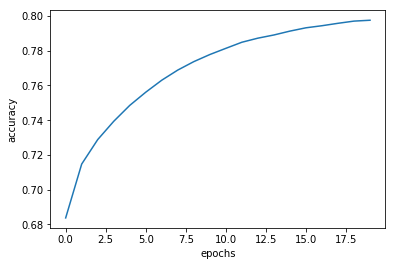

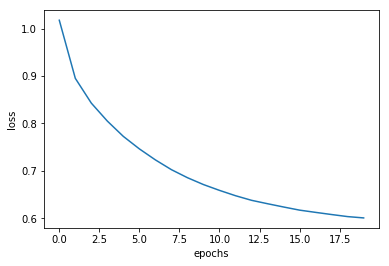

In [29]:
accuracy, loss = history.history['acc'], history.history['loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(epochs, loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [30]:
x_submission = test['processed'].values
x_submission_vec = np.array([text_to_array(_) for _ in x_submission])
y_submission = model.predict(x_submission_vec)
test['Category'] = np.argmax(y_submission, axis=1)

In [32]:
test[['itemid', 'Category']].to_csv('submission_final.csv', index=False)